# Adversarial X

**Разработчики: Алексей Умнов, Александр Шевченко, Ирина Сапарина**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aosokin/dl_cshse_ami/blob/master/2021-fall/homeworks_small/shw7/DL21-fall-shw7.ipynb)

In [1]:
# Load dependencies
!wget --quiet --show-progress "https://raw.githubusercontent.com/aosokin/dl_cshse_ami/master/2021-fall/homeworks_small/shw7/net_weights.pth"
!wget --quiet --show-progress "https://raw.githubusercontent.com/aosokin/dl_cshse_ami/master/2021-fall/homeworks_small/shw7/test_array_sign.pth"
!wget --quiet --show-progress "https://raw.githubusercontent.com/aosokin/dl_cshse_ami/master/2021-fall/homeworks_small/shw7/test_array_step.pth"

net_weights.pth     100%[===================>]  23.85K  --.-KB/s    in 0s      
test_array_sign.pth 100%[===================>]     503  --.-KB/s    in 0s      
test_array_step.pth 100%[===================>]     503  --.-KB/s    in 0s      


# Adversarial examples

В этом разделе мы будем создавать adversarial примеры для типичной архитектуры сетей. Для начала нужно сделать простую сверточную сеть для классификации (2-3 слоя) и обучить ее до нормального качества (>97%). Для экономии времени не нужно обучать ее слишком много эпох как мы это делали ранее.

*Упражнение.* Можете попробовать дома обучить сеть до сходимости и сравнить, какой из вариантов более уязвим к таким атакам.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

In [40]:
input_size = 784
num_classes = 10
batch_size = 256

train_dataset = dsets.MNIST(root='./MNIST/', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./MNIST/', 
                           train=False, 
                           transform=transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,         
                                          shuffle=False)

In [41]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = 20
        self.layers = nn.Sequential(
            nn.Conv2d(1, self.a, 5, padding=2, stride=2),
            nn.BatchNorm2d(self.a),
            nn.ReLU(),
            # nn.MaxPool2d(2, stride=2),
            nn.Conv2d(self.a, 2*self.a, 3, padding=1, stride=2),
            nn.BatchNorm2d(2*self.a),
            nn.ReLU(),
            # nn.MaxPool2d(2, stride=2),
            nn.Conv2d(2*self.a, 4*self.a, 3, padding=1, stride=2),
            nn.BatchNorm2d(4*self.a),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        )
        self.dense = nn.Linear(4*self.a, num_classes)
        self.last = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        bs = x.shape[0]
        x = x.view(bs, 1, 28, 28)
        x = self.layers(x)
        x = x.view(bs, 4*self.a)
        x = self.dense(x)
        x = self.last(x)
        return x


In [42]:
from tqdm import trange

        
def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for _, (x_batch, y_batch) in zip(trange(len(train_loader)), train_loader):
        data = x_batch
        target = y_batch
        optimizer.zero_grad()
        output = model(data)   
        
        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):  
        data = x_batch
        target = y_batch
        output = model(data)
        loss = F.nll_loss(output, target)
        
        pred = torch.max(output, 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, opt, batchsize=batchsize)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')   
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))

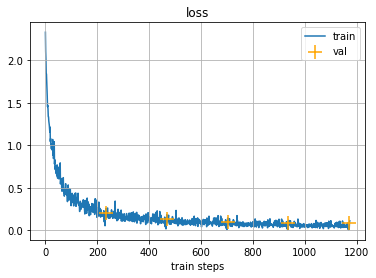

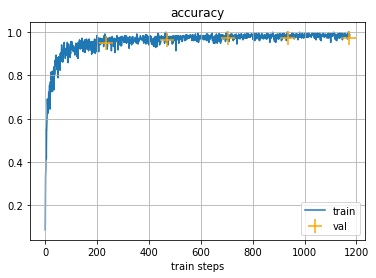

Final error: 2.47%
CPU times: user 1min 58s, sys: 4.85 s, total: 2min 3s
Wall time: 2min 3s


In [43]:
%%time

model = ConvNet()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train(model, opt, 5)

Теперь возьмем несколько изображений, которые мы будем пытаться искажать.

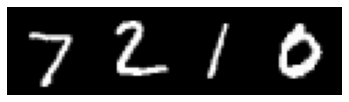

[7 2 1 0]


In [44]:
import torchvision

inputs, labels = iter(test_loader).next()
inputs = inputs[:4]
labels = labels[:4]

def imshow(images):
    img = images
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
imshow(inputs)
print(labels.numpy())

Реализуйте простой способ adversarial-атаки: сделайте шаг градиентного подъема по входам (изображениям) для увеличения ошибки классификации. Подберите шаг, чтобы значения предсказания уже начинали меняться, но визуально цифра мало менялась (т.е. вы бы по-прежнему ее распознали как ту же цифру с высокой уверенностью).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


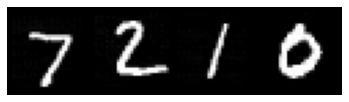

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch accuracy:  0.0
predicted labels:  tensor([4, 5, 4, 2])


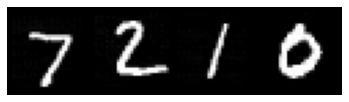

In [51]:
# я сделал круче: под каждую картинку шаг подгонятеся индивидуально, поэтому модель ошибается на всех картинках
from copy import deepcopy

def corrupt_simple_my(inputs, labels, model, weight):
    # YOUR CODE HERE
    a = 0.5
    w = torch.tensor([0.001] * 4)
    acc = 1.0
    i = 0
    while acc > 0.1 and i < 100:
      i += 1
      x = torch.clone(inputs)
      x.requires_grad = True
      loss = F.nll_loss(model(x), labels)
      loss.backward()
      outputs = x + w.unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, 1, 28, 28) * x.grad
      preds = model(outputs)
      pred = torch.max(preds, 1)[1]
      w *= 1 + a * torch.eq(pred, labels).float() 
      acc = torch.eq(pred, labels).float().mean().item()
    imshow(outputs)
    print('batch accuracy: ', acc)
    print('predicted labels: ', pred)
    return outputs


corrupted_inputs = corrupt_simple_my(inputs, labels, model, 200)
imshow(corrupted_inputs.data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch accuracy:  0.0
predicted labels:  tensor([4, 5, 9, 2])


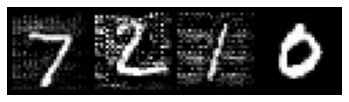

In [57]:
from copy import deepcopy

def corrupt_simple(inputs, labels, model, weight):
    bs = inputs.shape[0]
    x = torch.clone(inputs)
    x.requires_grad = True
    loss = F.nll_loss(model(x), labels)
    loss.backward()
    w = torch.tensor([weight] * bs)
    outputs = x + w.unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, 1, 28, 28) * x.grad
    preds = model(outputs)
    pred = torch.max(preds, 1)[1]
    acc = torch.eq(pred, labels).float().mean().item()
    print('batch accuracy: ', acc)
    print('predicted labels: ', pred)
    return outputs

corrupted_inputs = corrupt_simple(inputs, labels, model, 200)
imshow(corrupted_inputs.data)

In [58]:
class testConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )
        
        self.classifier = nn.Linear(12 * 12 * 4, 10)
        
    def forward(self, x):
        f = self.features(x.view(-1, 1, 28, 28))
        out = self.classifier(f.view(-1, 12 * 12 * 4))
        return F.log_softmax(out, dim=-1)

In [60]:
test_net = testConvNet()
test_dict = torch.load('net_weights.pth')
test_net.load_state_dict(test_dict)

corrupted_inputs_test = corrupt_simple(inputs, labels, test_net, 200)
outputs_ = test_net(corrupted_inputs_test)

golden_array = torch.load('test_array_step.pth')
assert np.allclose(outputs_.detach().numpy(), golden_array.detach().numpy(), atol=1e-4), "Check your corrupt_simple function"

batch accuracy:  0.75
predicted labels:  tensor([7, 0, 1, 0])


AssertionError: ignored

In [61]:
outputs = model(corrupted_inputs)
_, predicted = torch.max(outputs.data, 1)
print(predicted.numpy())

[4 5 9 2]


Видно, что в таком подходе приходится уже сильно исказить изображение, чтобы ответы начали меняться. Если вместо градиента использовать только его знак (по каждой координате), то результаты получаются лучше. Реализуйте такой метод.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch accuracy:  0.0
predicted labels:  tensor([4, 5, 9, 2])


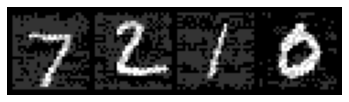

In [62]:
def corrupt_sign(inputs, labels, model, weight):
    # YOUR CODE HERE
    bs = inputs.shape[0]
    x = torch.clone(inputs)
    x.requires_grad = True
    loss = F.nll_loss(model(x), labels)
    loss.backward()
    w = torch.tensor([weight] * bs)
    outputs = x + w.unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, 1, 28, 28) * torch.sign(x.grad)
    preds = model(outputs)
    pred = torch.max(preds, 1)[1]
    acc = torch.eq(pred, labels).float().mean().item()
    print('batch accuracy: ', acc)
    print('predicted labels: ', pred)
  
    return outputs

corrupted_inputs = corrupt_sign(inputs, labels, model, 0.2)
imshow(corrupted_inputs.data) 

In [63]:
test_net = testConvNet()
test_dict = torch.load('net_weights.pth')
test_net.load_state_dict(test_dict)

corrupted_inputs_test = corrupt_sign(inputs, labels, test_net, 0.2)
outputs_ = test_net(corrupted_inputs_test)

golden_array = torch.load('test_array_sign.pth')
assert np.allclose(outputs_.detach().numpy(), golden_array.detach().numpy()), "Check your corrupt_sign function"

batch accuracy:  0.0
predicted labels:  tensor([3, 0, 2, 6])


AssertionError: ignored

In [64]:
outputs = model(corrupted_inputs)
_, predicted = torch.max(outputs.data, 1)
print(predicted.numpy())

[4 5 9 2]


Теперь посмотрим как сильно меняется точность на всей выборке.

In [65]:
def evaluate_network_attack(net, corrupt_function, weight):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data in test_loader:
        images, labels = data
        images = corrupt_function(images, labels, net, weight)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).long().squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

    print('Accuracy %d %% \n' % (100. * sum(class_correct) / sum(class_total)))
        
    for i in range(10):
        print('Accuracy of %2s : %2d %%' % (
              i, 100. * class_correct[i] / class_total[i]))

In [66]:
evaluate_network_attack(model, corrupt_simple, 200)

batch accuracy:  0.81640625
predicted labels:  tensor([7, 2, 1, 0, 4, 1, 4, 8, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 5, 4, 7, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 4, 3, 4, 7, 2, 2, 1, 2, 1, 1, 2, 4, 4, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 5, 0, 4, 1, 9, 4, 7, 8, 5, 3, 7, 9, 6, 4, 3, 0, 7, 0,
        2, 7, 1, 7, 3, 2, 9, 0, 9, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 1, 9, 1, 4,
        4, 7, 5, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 1, 3, 9, 7, 9, 4, 4, 4, 2,
        5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 4, 2, 1,
        7, 1, 8, 2, 0, 3, 9, 5, 5, 5, 1, 5, 6, 0, 2, 4, 4, 6, 5, 4, 6, 5, 4, 2,
        1, 4, 4, 9, 2, 3, 2, 8, 1, 9, 1, 8, 1, 8, 5, 0, 3, 4, 2, 5, 0, 1, 1, 5,
        0, 5, 7, 5, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 8, 9, 3, 9, 2,
        3, 3, 5, 5, 7, 5, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 5, 9, 7, 9, 2, 2, 4, 1,
        5, 5, 5, 7, 2, 6, 0, 2, 4, 2, 9, 1, 9, 5, 7, 7])
batch accuracy:  0.71484375
predicted labels:  tensor([2, 1, 2, 3, 8, 5, 7, 7, 8, 1, 2, 1, 5, 0,

In [67]:
evaluate_network_attack(model, corrupt_sign, 0.2)

batch accuracy:  0.0
predicted labels:  tensor([4, 5, 9, 2, 9, 9, 3, 8, 6, 4, 3, 3, 4, 7, 4, 3, 7, 8, 6, 3, 7, 3, 7, 3,
        5, 3, 8, 3, 3, 3, 9, 5, 6, 8, 4, 8, 2, 3, 8, 9, 9, 2, 3, 4, 6, 8, 5, 8,
        9, 5, 3, 5, 9, 2, 5, 7, 3, 9, 4, 4, 5, 3, 5, 2, 4, 3, 7, 5, 9, 5, 8, 1,
        5, 7, 9, 4, 5, 5, 3, 8, 4, 3, 8, 9, 7, 7, 8, 7, 3, 9, 6, 3, 4, 9, 4, 8,
        9, 4, 3, 2, 3, 7, 3, 2, 3, 5, 8, 9, 5, 8, 5, 1, 6, 2, 3, 3, 9, 3, 4, 7,
        3, 6, 9, 3, 8, 4, 3, 9, 3, 3, 3, 3, 3, 2, 7, 5, 3, 8, 3, 9, 3, 8, 2, 5,
        8, 5, 7, 8, 2, 3, 5, 5, 8, 8, 9, 2, 3, 3, 2, 3, 5, 3, 2, 3, 3, 3, 2, 2,
        5, 3, 3, 8, 8, 5, 9, 8, 9, 7, 5, 3, 5, 5, 9, 1, 3, 4, 3, 3, 7, 9, 9, 5,
        1, 3, 3, 4, 9, 3, 3, 3, 2, 3, 9, 9, 9, 6, 5, 3, 5, 3, 3, 8, 3, 2, 3, 3,
        6, 3, 8, 9, 8, 5, 8, 8, 6, 5, 7, 3, 9, 5, 0, 5, 5, 7, 8, 5, 5, 5, 3, 5,
        2, 5, 7, 3, 3, 6, 5, 2, 9, 3, 9, 9, 7, 3, 8, 8])
batch accuracy:  0.0
predicted labels:  tensor([3, 1, 8, 0, 7, 7, 9, 4, 2, 5, 2, 4, 5, 2, 6, 7, 5, 3, 3

# Super-resolution

В этой части вам предстоит реализовать простейшую архитектуру для решения задачи image super-resolution.

Мы будем увеличивать изображения размера (14,14) в два раза по каждому измерению. Как правило, перед подачей на вход нейросети изображение низкого разрешения увеличивают до нужного размера билинейной интерполяцией, а нейросеть улучшает результат интерпляции, не меняя пространственные размеры изображения.

Реализуйте нейросеть из двух сверточных слоев (5 фильтров на каждом слое), которая будет получать на вход черно-белое изображение и выдавать на выход изображение такого же размера. Нейросеть должна предсказывать добавку, которую необходимо прибавить к полученному на вход изображению низкого качества. 

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,         
                                          shuffle=False)

In [6]:
n_kernels = 5

class SuperResolutionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, n_kernels, 3, padding=1),
            nn.BatchNorm2d(n_kernels),
            nn.ReLU(),
            nn.Conv2d(n_kernels, n_kernels, 3, padding=1),
            nn.BatchNorm2d(n_kernels),
            nn.ReLU(),  
            nn.Conv2d(n_kernels, 1, 1, padding=0), 
            nn.ReLU(),
        )

    def forward(self, x):
        output = self.cnn1(x)
        return output + x

In [7]:
srcnn = SuperResolutionNetwork()

In [8]:
from tqdm import trange

def low_res_and_high_res(images_batch):
    result = images_batch.clone()
    low_res_transform = transforms.Resize((14,14))
    high_res_transform = transforms.Resize((28,28))
    toTensorTransform = transforms.ToTensor()
    toImageTransform = transforms.ToPILImage()
    for i in range(images_batch.size()[0]):
        result[i] = toTensorTransform(high_res_transform(low_res_transform(toImageTransform(images_batch[i]))))
    return result

def train_epoch(model, optimizer, batchsize=32):
    loss_log = []
    model.train()
    for _, (x_batch_base, _) in zip(trange(len(train_loader)), train_loader):
        x_batch = x_batch_base.float()
        data = low_res_and_high_res(x_batch)
        target = x_batch
        optimizer.zero_grad()
        output = model(data)        
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.data.cpu().item()
        loss_log.append(loss)
    return loss_log   

def test(model):
    loss_log = []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):    
        x_batch = x_batch.float()
        data = low_res_and_high_res(x_batch)
        target = x_batch
        output = model(data)
        loss = F.mse_loss(output, target)        
        loss = loss.data.cpu().item()
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, batchsize=batch_size)
        val_loss = test(model)
        train_log.extend(train_loss)
        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        clear_output()
        plot_history(train_log, val_log)    

Оптимизируйте сеть с параметрами, указанными ниже.

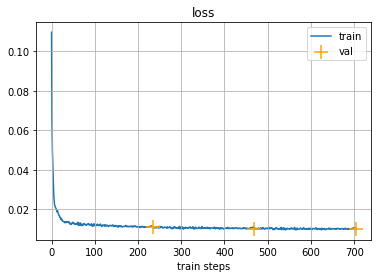

CPU times: user 1min 45s, sys: 9.57 s, total: 1min 55s
Wall time: 1min 55s


In [9]:
%%time 

opt = torch.optim.Adam(srcnn.parameters(), lr=0.005)
train(srcnn, opt, 3)

Код ниже визуализирует исходные изображения (28,28) и реконструкции, полученные с помощью нейросети. Не удивляйтесь, есть качество реконструкций покажется низким, так как MSE-loss, который мы использовали при обучении, не является оптимальным для задачи super-resolution (гораздо лучше работают adversarial-сети).

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


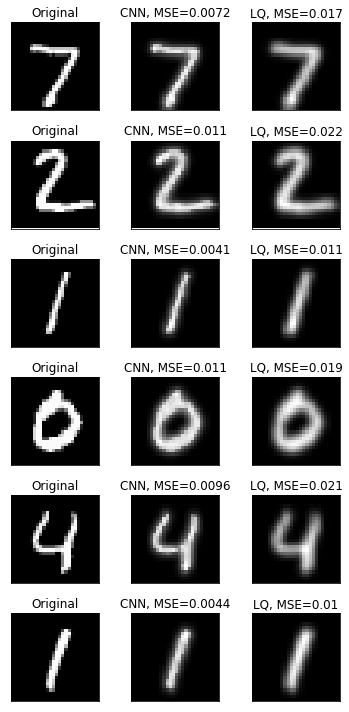

In [10]:
test_images = test_dataset.test_data.float() / 255
test_images_blurred = low_res_and_high_res(test_images[:100].view(-1,1,28,28))
result_cnn = srcnn(test_images_blurred)

examplesCount = 6
plt.figure(figsize=[5, 10])
for i in range(examplesCount):
    plt.subplot(examplesCount, 3, i * 3 + 1)
    plt.title("Original")
    plt.imshow(test_images[i].numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(examplesCount, 3, i * 3 + 2)
    mse = np.mean((test_images[i].numpy() - result_cnn[i].data.numpy())**2)
    plt.title("CNN, MSE={:.2}".format(mse))
    plt.imshow(result_cnn[i].data.numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(examplesCount, 3, i * 3 + 3)
    mse = np.mean((test_images[i].numpy() - test_images_blurred[i].numpy())**2)
    plt.title("LQ, MSE={:.2}".format(mse))
    plt.imshow(test_images_blurred[i].numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

# Adversarial networks

На этом семинаре мы поработаем с adversarial-архитектурами. Мы не будем обучать полноценную генеративную модель (GAN), так как это потребует много времени, а вместо этого вернемся к задаче повышения разрешения изображений и попробуем улучшить нашу модель с помощью advesarial-подхода (получится упрощенный SRGAN).

Как мы обсуждали ранее, MSE хоть и является простой и удобной метрикой, она плохо отражает визуальные характеристики изображений. Поэтому мы добавим дискриминатор, который будет пытаться отличить изображения высокого качества от наших результатов, и в модели повышающей разрешение будем пытаться его обмануть.

Если это записать строго, то у нас будут две сети: $D$ - дискриминатор и $E$ - сеть, повышающая разрешение, и оптимизировать мы для них будем следующие целевые функции соответсвенно:

$$
    \min_D \bigl[ \mathrm{BCE}(D(E(x_l)), 0) + \mathrm{BCE}(D(x_h), 1) \bigr],
$$

$$
    \min_E \bigl[ \| E(x_l) - x_h \|_2^2 - \lambda \cdot \mathrm{BCE}(D(E(x_l)), 0) \bigr],
$$

где $BCE(l, y)$ - бинарная кросс-энтропия между ответами $l$ и метками $y$, $x_l$ - изображения низкого качества, $x_h$ - изображения высокого качества.

*Упражнение.* Почему в целевой функции для $D$ нет компоненты $\mathrm{BCE}(D(x_h), 1)$?

Создайте простую сеть (2-3 слоя) для бинарной классификации изображений.

In [34]:
class DiscriminatorNetwork(nn.Module): # возьму из первой части дз и уменьшу a
    def __init__(self):
        super().__init__()
        self.a = 10
        self.layers = nn.Sequential(
            nn.Conv2d(1, self.a, 5, padding=2, stride=2),
            nn.BatchNorm2d(self.a),
            nn.ReLU(),
            nn.Conv2d(self.a, 2*self.a, 3, padding=1, stride=2),
            nn.BatchNorm2d(2*self.a),
            nn.ReLU(),
            nn.Conv2d(2*self.a, 4*self.a, 3, padding=1, stride=2),
            nn.BatchNorm2d(4*self.a),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        )
        self.dense = nn.Linear(4*self.a, 2)
        self.last = nn.Softmax(dim=-1)

    def forward(self, x):
        bs = x.shape[0]
        x = x.view(bs, 1, 28, 28)
        x = self.layers(x)
        x = x.view(bs, 4*self.a)
        x = self.dense(x)
        x = self.last(x)
        return x

In [35]:
srgan = SuperResolutionNetwork()
disc = DiscriminatorNetwork()

При оптимизации adversarial-архитектур возникает дополнительная сложность - сети необходимо оптимизировать поочередно. Иногда для них приходится подбирать оптимальное соотношение числа шагов, но мы ограничимся вариантом 1:1. Допишите недостающий код оптимизации ниже.

In [36]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,         
                                          shuffle=False)

In [37]:
from tqdm import trange

def low_res_and_high_res(images_batch):
    result = images_batch.clone()
    low_res_transform = transforms.Resize((14,14))
    high_res_transform = transforms.Resize((28,28))
    toTensorTransform = transforms.ToTensor()
    toImageTransform = transforms.ToPILImage()
    for i in range(images_batch.size()[0]):
        result[i] = toTensorTransform(high_res_transform(low_res_transform(toImageTransform(images_batch[i]))))
    return result


DISC_LOSS_WEIGHT = 0.1

def losses(model, disc, x_batch):
    data = low_res_and_high_res(x_batch)
    target = x_batch
    output = model(data)
    
    # YOUR CODE
    disc_output_on_E = disc(output)
    disc_output_on_real = disc(target)
    criterion = nn.BCELoss()

    disc_loss = criterion(disc_output_on_E, torch.zeros_like(disc_output_on_E)) + criterion(disc_output_on_real, torch.ones_like(disc_output_on_real))
    mse_loss = F.mse_loss(output, target)
    model_loss = mse_loss - DISC_LOSS_WEIGHT * criterion(disc_output_on_E, torch.zeros_like(disc_output_on_E)) 
    
    return disc_loss, model_loss
    

def train_epoch(model, disc, m_opt, d_opt, batchsize=32):
    d_loss_log = []
    m_loss_log = []
    model.train()
    disc.train()
    for batch_num, (x_batch_base, _) in zip(trange(len(train_loader)), train_loader):
        x_batch = x_batch_base.float()
        d_loss, m_loss = losses(model, disc, x_batch)
            
        # YOUR CODE 
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True)
        m_opt.zero_grad()
        m_loss.backward()
        d_opt.step()
        m_opt.step()
            
        d_loss_log.append(d_loss.item())
        m_loss_log.append(m_loss.item())
    return d_loss_log, m_loss_log 

def test(model, disc):
    d_loss_log = []
    m_loss_log = []
    model.eval()
    disc.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        d_loss, m_loss = losses(model, disc, x_batch)
        d_loss_log.append(d_loss.item())
        m_loss_log.append(m_loss.item())
    return d_loss_log, m_loss_log 

def plot_history(train_history, val_history, title='loss'):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_history[0], label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.title('Discriminator loss')
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_history[1], label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 2], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.title('Model loss')
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    
    plt.show()
    
def train(model, disc, m_opt, d_opt, n_epochs):
    train_log = [[], []]
    val_log = []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, disc, m_opt, d_opt, batchsize=batch_size)
        val_loss = test(model, disc)
        train_log[0].extend(train_loss[0])
        train_log[1].extend(train_loss[1])
        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss[0]), np.mean(val_loss[1])))
        clear_output()
        plot_history(train_log, val_log)    

Теперь запустим оптимизацию. Большая проблема при работе с adversarial-моделями - в том, что по графикам оптимизации мало чего понятно. То есть по ним можно увидеть какое-то совсем плохое поведение и, возможно, найти ошибки в коде, но вот понять, дообучилась ли сеть, или ее еще стоит пообучать, часто нельзя. Обычно все метрики просто колеблются вокруг константы, но при этом сеть обучается (по очереди происходит небольшое улучшение дискриминатора, а потом оно тут же убирается основной сетью).

Обучите сеть на 2-3 эпохах и добейтесь, чтобы влияние adversarial-потерь было заметно (на примерах ниже). Для этого потребуется, чтобы качество дискриминатора не ушло совсем в 0. Возможно, придется немного поиграться с параметрами.

Потом дома можно оставить обучение на 5-10 эпох и увидеть изменения в качестве.

Также обратите внимание, что MSE для adversarial-архитектуры выходит хуже, чем обычной. Но мы так и планировали сделать - ведь MSE плохо оценивает визуальное качество.

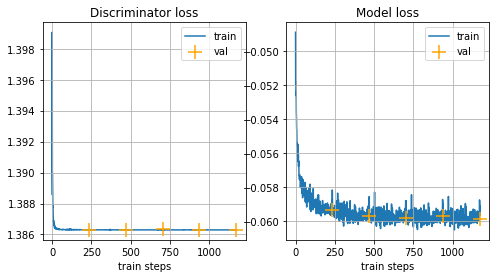

CPU times: user 5min 58s, sys: 16.3 s, total: 6min 14s
Wall time: 6min 13s


In [38]:
%%time

m_opt = torch.optim.Adam(srgan.parameters(), lr=0.005)
d_opt = torch.optim.Adam(disc.parameters(), lr=0.005)
train(srgan, disc, m_opt, d_opt, 5)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


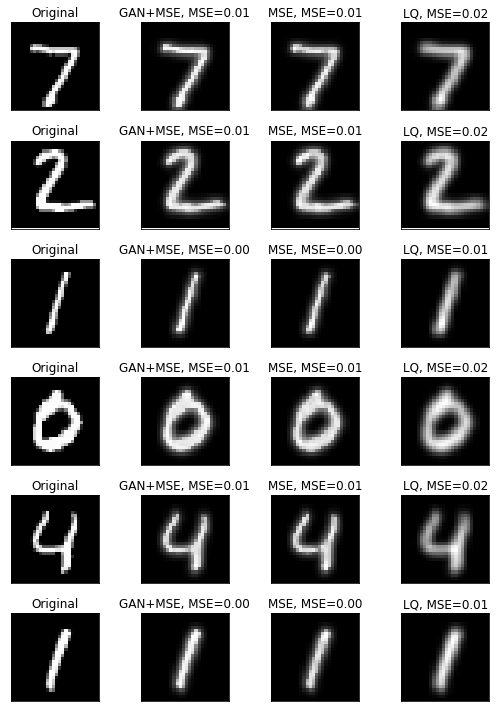

In [68]:
test_images = test_dataset.test_data.float() / 255
test_images_blurred = low_res_and_high_res(test_images[:100].view(-1,1,28,28))
result_cnn = srcnn(test_images_blurred)
result_gan = srgan(test_images_blurred)

examplesCount = 6
rows, cols = examplesCount, 4
plt.figure(figsize=[7, 10])
for i in range(examplesCount):
    plt.subplot(rows, cols, i * cols + 1)
    plt.title("Original")
    plt.imshow(test_images[i].numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(rows, cols, i * cols + 2)
    mse = np.mean((test_images[i].numpy() - result_gan[i].data.numpy())**2)
    plt.title("GAN+MSE, MSE={:.2f}".format(mse))
    plt.imshow(result_gan[i].data.numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(rows, cols, i * cols + 3)
    mse = np.mean((test_images[i].numpy() - result_cnn[i].data.numpy())**2)
    plt.title("MSE, MSE={:.2f}".format(mse))
    plt.imshow(result_cnn[i].data.numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(rows, cols, i * cols + 4)
    mse = np.mean((test_images[i].numpy() - test_images_blurred[i].numpy())**2)
    plt.title("LQ, MSE={:.2f}".format(mse))
    plt.imshow(test_images_blurred[i].numpy().reshape([28, 28]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()